#### Imports and Setup

In [1]:
# Cell 1: Imports & Setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm import tqdm
import pandas as pd
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Global parameters
D = 10  # Input dimension
N_FEATURES = 10  # Number of orthogonal features
BATCH_SIZE = 4096
N_SAMPLES = 100000  # Total samples for training
LEARNING_RATE = 5e-4  # From MP-SAE paper
N_EPOCHS = 50

# SAE configuration
SAE_WIDTHS = [5, 10, 100]  # Number of latents
SPARSITY_LEVELS = [5, 10, 20, 50]  # L0 targets for TopK, T steps for MP-SAE

print("Setup complete!")
print(f"Will test SAE widths: {SAE_WIDTHS}")
print(f"Will test sparsity levels: {SPARSITY_LEVELS}")

Using device: cuda
Setup complete!
Will test SAE widths: [5, 10, 100]
Will test sparsity levels: [5, 10, 20, 50]


#### Data generation

In [2]:
# Cell 2: Data Generation - Hierarchical Features
class HierarchicalDataGenerator:
    def __init__(self, dim=10, n_features=10):
        """
        Generate hierarchical feature data similar to feature hedging paper.
        Features are organized in pairs: (f0->f1, f2->f3, f4->f5, f6->f7, f8->f9)
        """
        self.dim = dim
        self.n_features = n_features
        assert n_features % 2 == 0, "Number of features must be even for hierarchical pairs"
        
        # Create orthogonal feature directions
        self.feature_dirs = self._create_orthogonal_features()
        
        # Define hierarchical structure: parent -> child pairs
        self.pairs = [(i, i+1) for i in range(0, n_features, 2)]
        
        # Set different firing probabilities for variety
        # Parents have higher base probability than children
        self.parent_probs = [0.25, 0.20, 0.30, 0.15, 0.35]  # f0, f2, f4, f6, f8
        self.child_given_parent_probs = [0.2, 0.25, 0.15, 0.3, 0.1]  # f1|f0, f3|f2, etc.
        
        print("Hierarchical structure:")
        for i, (parent, child) in enumerate(self.pairs):
            print(f"f{parent} -> f{child}: P(f{parent})={self.parent_probs[i]:.2f}, "
                  f"P(f{child}|f{parent})={self.child_given_parent_probs[i]:.2f}")
    
    def _create_orthogonal_features(self):
        """Create orthogonal unit vectors as feature directions"""
        # Use QR decomposition to get orthogonal vectors
        random_matrix = np.random.randn(self.dim, self.n_features)
        Q, _ = np.linalg.qr(random_matrix)
        return Q.T  # Shape: (n_features, dim)
    
    def generate_batch(self, batch_size):
        """Generate a batch of hierarchical feature data"""
        activations = np.zeros((batch_size, self.dim))
        feature_activities = np.zeros((batch_size, self.n_features))
        
        for i in range(batch_size):
            # For each hierarchical pair
            for pair_idx, (parent_idx, child_idx) in enumerate(self.pairs):
                # Sample parent activation
                if np.random.random() < self.parent_probs[pair_idx]:
                    # Parent fires with magnitude 1.0
                    activations[i] += self.feature_dirs[parent_idx]
                    feature_activities[i, parent_idx] = 1.0
                    
                    # Sample child activation given parent is active
                    if np.random.random() < self.child_given_parent_probs[pair_idx]:
                        activations[i] += self.feature_dirs[child_idx]
                        feature_activities[i, child_idx] = 1.0
        
        return torch.tensor(activations, dtype=torch.float32), torch.tensor(feature_activities, dtype=torch.float32)
    
    def get_feature_directions(self):
        """Return the true feature directions for analysis"""
        return torch.tensor(self.feature_dirs, dtype=torch.float32)

# Create data generator
data_gen = HierarchicalDataGenerator(dim=D, n_features=N_FEATURES)

# Generate sample data to verify
sample_batch, sample_activities = data_gen.generate_batch(1000)
print(f"\nSample batch shape: {sample_batch.shape}")
print(f"Sample activities shape: {sample_activities.shape}")
print(f"Mean L0 sparsity: {sample_activities.sum(dim=1).mean():.2f}")
print(f"Activity rates per feature: {sample_activities.mean(dim=0).numpy()}")

Hierarchical structure:
f0 -> f1: P(f0)=0.25, P(f1|f0)=0.20
f2 -> f3: P(f2)=0.20, P(f3|f2)=0.25
f4 -> f5: P(f4)=0.30, P(f5|f4)=0.15
f6 -> f7: P(f6)=0.15, P(f7|f6)=0.30
f8 -> f9: P(f8)=0.35, P(f9|f8)=0.10

Sample batch shape: torch.Size([1000, 10])
Sample activities shape: torch.Size([1000, 10])
Mean L0 sparsity: 1.52
Activity rates per feature: [0.259 0.052 0.189 0.041 0.321 0.051 0.159 0.044 0.358 0.044]


#### Top-K SAE

In [3]:
# Cell 3: TopK SAE Architecture
class TopKSAE(nn.Module):
    def __init__(self, input_dim, n_latents, k):
        """
        TopK Sparse Autoencoder with untied weights (as per feature hedging paper)
        
        Args:
            input_dim: Input dimension
            n_latents: Number of latent features
            k: Number of top activations to keep
        """
        super().__init__()
        self.input_dim = input_dim
        self.n_latents = n_latents
        self.k = k
        
        # Encoder and decoder (untied)
        self.encoder = nn.Linear(input_dim, n_latents, bias=True)
        self.decoder = nn.Linear(n_latents, input_dim, bias=True)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights following SAE best practices"""
        # Encoder: small random weights
        nn.init.xavier_uniform_(self.encoder.weight)
        nn.init.zeros_(self.encoder.bias)
        
        # Decoder: normalized columns
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.decoder.bias)
        
        # Normalize decoder columns to unit norm
        with torch.no_grad():
            self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)
    
    def encode(self, x):
        """Encode input with TopK sparsity"""
        # Remove decoder bias (centering)
        x_centered = x - self.decoder.bias
        
        # Linear projection
        z = self.encoder(x_centered)
        
        # TopK sparsity
        k_actual = min(self.k, z.size(-1))
        topk_vals, topk_indices = torch.topk(torch.abs(z), k_actual, dim=-1)
        
        # Create sparse representation
        z_sparse = torch.zeros_like(z)
        z_sparse.scatter_(-1, topk_indices, z.gather(-1, topk_indices))
        
        return z_sparse
    
    def decode(self, z):
        """Decode sparse representation"""
        return self.decoder(z)
    
    def forward(self, x):
        """Forward pass"""
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z
    
    def compute_loss(self, x, x_recon, z):
        """Compute reconstruction loss (no L1 penalty for TopK)"""
        mse_loss = nn.functional.mse_loss(x_recon, x)
        return mse_loss
    
    def get_sparsity(self, z):
        """Get actual L0 sparsity"""
        return (z != 0).sum(dim=-1).float().mean()

# Test TopK SAE
print("Testing TopK SAE...")
test_sae = TopKSAE(input_dim=D, n_latents=20, k=5)
test_batch, _ = data_gen.generate_batch(32)
test_recon, test_z = test_sae(test_batch)
print(f"Input shape: {test_batch.shape}")
print(f"Reconstruction shape: {test_recon.shape}")
print(f"Latent shape: {test_z.shape}")
print(f"Sparsity: {test_sae.get_sparsity(test_z):.2f}")
print("TopK SAE test passed!")

Testing TopK SAE...
Input shape: torch.Size([32, 10])
Reconstruction shape: torch.Size([32, 10])
Latent shape: torch.Size([32, 20])
Sparsity: 3.59
TopK SAE test passed!


#### MP-SAE

In [7]:
# Cell 4: MP-SAE Architecture (Algorithm 1)
class MPSAE(nn.Module):
    def __init__(self, input_dim, n_latents, max_steps):
        """
        Matching Pursuit SAE with tied weights (as per MP-SAE paper)
        Implements Algorithm 1 from "From Flat to Hierarchical" paper
        
        Args:
            input_dim: Input dimension (m in paper)
            n_latents: Dictionary size (p in paper)  
            max_steps: Maximum MP steps (T in paper)
        """
        super().__init__()
        self.input_dim = input_dim
        self.n_latents = n_latents
        self.max_steps = max_steps
        
        # Dictionary D and bias (tied weights: encoder = decoder^T)
        self.dictionary = nn.Parameter(torch.randn(input_dim, n_latents))
        self.bias_pre = nn.Parameter(torch.zeros(input_dim))
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize dictionary with normalized columns"""
        nn.init.xavier_uniform_(self.dictionary.data)
        # Normalize dictionary columns to unit norm
        with torch.no_grad():
            self.dictionary.data = nn.functional.normalize(self.dictionary.data, dim=0)
        nn.init.zeros_(self.bias_pre)
    
    def encode(self, x):
        """
        MP encoding following Algorithm 1
        
        Args:
            x: Input batch [batch_size, input_dim]
        
        Returns:
            z: Sparse code [batch_size, n_latents]
            x_recon: Final reconstruction [batch_size, input_dim]
        """
        batch_size = x.size(0)
        
        # Algorithm 1, Line 2: Initialize residual
        residual = x - self.bias_pre  # r^(0) = x - b_pre
        
        # Algorithm 1, Line 3: Initialize reconstruction  
        x_recon = self.bias_pre.unsqueeze(0).expand(batch_size, -1)  # x̂^(0) = b_pre
        
        # Algorithm 1, Line 4: Initialize sparse code
        z = torch.zeros(batch_size, self.n_latents, device=x.device)
        
        # Algorithm 1, Lines 5-10: MP iterations
        for t in range(self.max_steps):
            # Line 6: Find best matching feature j^(t) = argmax_j (D^T r^(t))_j
            correlations = torch.matmul(residual, self.dictionary)  # [batch_size, n_latents]
            best_indices = torch.argmax(torch.abs(correlations), dim=-1)  # [batch_size]
            
            # Line 7: Compute activation z_j^(t) = D_j^T r^(t)
            batch_indices = torch.arange(batch_size, device=x.device)
            activations = correlations[batch_indices, best_indices]  # [batch_size]
            
            # Update sparse code
            z[batch_indices, best_indices] += activations

            # Line 8: Update reconstruction x̂^(t+1) = x̂^(t) + z_j^(t) D_j^(t)
            selected_dict_vectors = self.dictionary[:, best_indices].T  # [batch_size, input_dim]
            x_recon = x_recon + activations.unsqueeze(-1) * selected_dict_vectors
            
            # Line 9: Update residual r^(t+1) = r^(t) - z_j^(t) D_j^(t)
            residual = residual - activations.unsqueeze(-1) * selected_dict_vectors

            
            # Optional early stopping if residual is very small
            if torch.norm(residual).item() < 1e-6:
                break
        
        return z, x_recon
    
    def forward(self, x):
        """Forward pass"""
        z, x_recon = self.encode(x)
        return x_recon, z
    
    def compute_loss(self, x, x_recon, z):
        """Compute reconstruction loss (no sparsity penalty - controlled by T)"""
        mse_loss = nn.functional.mse_loss(x_recon, x)
        return mse_loss
    
    def get_sparsity(self, z):
        """Get actual L0 sparsity"""
        return (z != 0).sum(dim=-1).float().mean()
    
    def get_dictionary(self):
        """Get normalized dictionary for analysis"""
        return nn.functional.normalize(self.dictionary, dim=0)

# Test MP-SAE
# Test MP-SAE
print("Testing MP-SAE...")
test_mp_sae = MPSAE(input_dim=D, n_latents=20, max_steps=5)
test_batch, _ = data_gen.generate_batch(32)
test_recon, test_z = test_mp_sae(test_batch)
print(f"Input shape: {test_batch.shape}")
print(f"Reconstruction shape: {test_recon.shape}")
print(f"Latent shape: {test_z.shape}")
print(f"Sparsity: {test_mp_sae.get_sparsity(test_z):.2f}")
print("MP-SAE test passed!")

print("\nTesting residual orthogonality...")
with torch.no_grad():
    x_sample = test_batch[:1]                         # [1, input_dim]
    residual = x_sample - test_mp_sae.bias_pre        # [1, input_dim]

    # One MP step
    correlations = residual @ test_mp_sae.dictionary   # [1, n_latents]
    best_idx = torch.argmax(torch.abs(correlations), dim=-1).item()  # int
    activation = correlations[0, best_idx]             # scalar tensor

    # Pull out the atom as a 1-D vector
    atom = test_mp_sae.dictionary[:, best_idx]         # [input_dim]

    # Compute the new residual as a 1-D vector
    new_residual = residual[0] - activation * atom      # [input_dim]

    # Now you can take a proper dot product of two 1-D tensors
    orthogonality_check = torch.dot(atom, new_residual)
    print(f"Orthogonality check (should be ~0): {orthogonality_check.item():.6f}")

Testing MP-SAE...
Input shape: torch.Size([32, 10])
Reconstruction shape: torch.Size([32, 10])
Latent shape: torch.Size([32, 20])
Sparsity: 3.88
MP-SAE test passed!

Testing residual orthogonality...
Orthogonality check (should be ~0): -0.000000


#### Training functions

In [8]:
# Cell 5: Training Functions
def train_sae(model, data_generator, n_epochs, batch_size, learning_rate, model_type="TopK"):
    """
    Train SAE model
    
    Args:
        model: SAE model (TopK or MP-SAE)
        data_generator: Data generator
        n_epochs: Number of training epochs
        batch_size: Batch size
        learning_rate: Learning rate
        model_type: "TopK" or "MP-SAE"
    
    Returns:
        model: Trained model
        losses: Training losses
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Cosine decay scheduler (as used in MP-SAE paper)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
    
    losses = []
    n_batches_per_epoch = N_SAMPLES // batch_size
    
    print(f"Training {model_type} SAE...")
    print(f"Epochs: {n_epochs}, Batches per epoch: {n_batches_per_epoch}")
    
    model.train()
    for epoch in tqdm(range(n_epochs), desc=f"Training {model_type}"):
        epoch_losses = []
        
        for batch_idx in range(n_batches_per_epoch):
            # Generate batch
            x_batch, _ = data_generator.generate_batch(batch_size)
            x_batch = x_batch.to(device)
            
            # Forward pass
            x_recon, z = model(x_batch)
            
            # Compute loss
            loss = model.compute_loss(x_batch, x_recon, z)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Normalize decoder weights for TopK SAE
            if model_type == "TopK":
                with torch.no_grad():
                    model.decoder.weight.data = nn.functional.normalize(model.decoder.weight.data, dim=0)
            elif model_type == "MP-SAE":
                # Normalize dictionary columns for MP-SAE
                with torch.no_grad():
                    model.dictionary.data = nn.functional.normalize(model.dictionary.data, dim=0)
            
            epoch_losses.append(loss.item())
        
        # Step scheduler
        scheduler.step()
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get sparsity on validation batch
            with torch.no_grad():
                val_batch, _ = data_generator.generate_batch(batch_size)
                val_batch = val_batch.to(device)
                _, val_z = model(val_batch)
                sparsity = model.get_sparsity(val_z)
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}, Sparsity: {sparsity:.2f}")
    
    model.eval()
    return model, losses

def evaluate_reconstruction_quality(model, data_generator, n_samples=5000):
    """
    Evaluate reconstruction quality (R²)
    
    Args:
        model: Trained SAE model
        data_generator: Data generator
        n_samples: Number of samples for evaluation
    
    Returns:
        r2: R² score
        mse: MSE
        sparsity: Average sparsity
    """
    model.eval()
    
    all_originals = []
    all_reconstructions = []
    all_sparsities = []
    
    n_batches = n_samples // BATCH_SIZE + 1
    
    with torch.no_grad():
        for _ in range(n_batches):
            x_batch, _ = data_generator.generate_batch(BATCH_SIZE)
            x_batch = x_batch.to(device)
            
            x_recon, z = model(x_batch)
            sparsity = model.get_sparsity(z)
            
            all_originals.append(x_batch.cpu())
            all_reconstructions.append(x_recon.cpu())
            all_sparsities.append(sparsity.cpu())
    
    # Concatenate and limit to n_samples
    originals = torch.cat(all_originals)[:n_samples]
    reconstructions = torch.cat(all_reconstructions)[:n_samples]
    avg_sparsity = torch.stack(all_sparsities).mean()
    
    # Compute R² and MSE
    r2 = r2_score(originals.numpy().flatten(), reconstructions.numpy().flatten())
    mse = nn.functional.mse_loss(reconstructions, originals).item()
    
    return r2, mse, avg_sparsity.item()

print("Training functions defined!")

Training functions defined!


#### Initial analyses

In [9]:
# Cell 6: Basic Analyses - Recreation of Fig. 5 and Cosine Similarity Analysis

def run_systematic_comparison():
    """
    Run systematic comparison across SAE widths and sparsity levels
    Recreates Figure 5 from MP-SAE paper
    """
    results = []
    
    for width in SAE_WIDTHS:
        for sparsity in SPARSITY_LEVELS:
            # Skip configurations where sparsity > width
            if sparsity > width:
                continue
                
            print(f"\n{'='*50}")
            print(f"Training: Width={width}, Sparsity={sparsity}")
            print(f"{'='*50}")
            
            # Train TopK SAE
            topk_model = TopKSAE(input_dim=D, n_latents=width, k=sparsity)
            topk_model, topk_losses = train_sae(
                topk_model, data_gen, N_EPOCHS, BATCH_SIZE, LEARNING_RATE, "TopK"
            )
            
            # Train MP-SAE
            mp_model = MPSAE(input_dim=D, n_latents=width, max_steps=sparsity)
            mp_model, mp_losses = train_sae(
                mp_model, data_gen, N_EPOCHS, BATCH_SIZE, LEARNING_RATE, "MP-SAE"
            )
            
            # Evaluate both models
            topk_r2, topk_mse, topk_sparsity = evaluate_reconstruction_quality(topk_model, data_gen)
            mp_r2, mp_mse, mp_sparsity = evaluate_reconstruction_quality(mp_model, data_gen)
            
            # Store results
            results.append({
                'width': width,
                'target_sparsity': sparsity,
                'model_type': 'TopK',
                'r2': topk_r2,
                'mse': topk_mse,
                'actual_sparsity': topk_sparsity,
                'final_loss': topk_losses[-1]
            })
            
            results.append({
                'width': width,
                'target_sparsity': sparsity,
                'model_type': 'MP-SAE',
                'r2': mp_r2,
                'mse': mp_mse,
                'actual_sparsity': mp_sparsity,
                'final_loss': mp_losses[-1]
            })
            
            print(f"TopK - R²: {topk_r2:.3f}, MSE: {topk_mse:.4f}, Sparsity: {topk_sparsity:.1f}")
            print(f"MP-SAE - R²: {mp_r2:.3f}, MSE: {mp_mse:.4f}, Sparsity: {mp_sparsity:.1f}")
    
    return pd.DataFrame(results)

def plot_figure_5_recreation(results_df):
    """
    Plot Figure 5 recreation: R² vs Sparsity for different widths
    """
    fig, axes = plt.subplots(1, len(SAE_WIDTHS), figsize=(15, 4))
    if len(SAE_WIDTHS) == 1:
        axes = [axes]
    
    colors = {'TopK': 'blue', 'MP-SAE': 'red'}
    markers = {'TopK': 'o', 'MP-SAE': 's'}
    
    for i, width in enumerate(SAE_WIDTHS):
        ax = axes[i]
        width_data = results_df[results_df['width'] == width]
        
        for model_type in ['TopK', 'MP-SAE']:
            model_data = width_data[width_data['model_type'] == model_type]
            ax.plot(model_data['actual_sparsity'], model_data['r2'], 
                   color=colors[model_type], marker=markers[model_type], 
                   label=model_type, linewidth=2, markersize=8)
        
        ax.set_xlabel('Sparsity Level')
        ax.set_ylabel('R² Score')
        ax.set_title(f'Width = {width}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.suptitle('Reconstruction Performance (R²) vs Sparsity Level\n(Recreation of Fig. 5)', 
                 y=1.02, fontsize=14)
    plt.show()

def compute_cosine_similarities(model, model_type, data_generator):
    """
    Compute cosine similarities between learned and true features
    Similar to feature hedging paper analysis
    """
    model.eval()
    
    # Get true feature directions
    true_features = data_generator.get_feature_directions()  # [n_features, dim]
    
    if model_type == "TopK":
        # For TopK: decoder weights are the learned features
        learned_features = model.decoder.weight.data.cpu().T  # [n_latents, dim]
    else:  # MP-SAE
        # For MP-SAE: dictionary columns are the learned features
        learned_features = model.get_dictionary().cpu().T  # [n_latents, dim]
    
    # Normalize features
    true_features = nn.functional.normalize(true_features, dim=1)
    learned_features = nn.functional.normalize(learned_features, dim=1)
    
    # Compute cosine similarity matrix
    cos_sim_matrix = torch.matmul(learned_features, true_features.T)  # [n_latents, n_features]
    
    return cos_sim_matrix.detach().cpu().numpy()

def plot_cosine_similarity_heatmaps(results_df, data_gen):
    """
    Plot cosine similarity heatmaps for different configurations
    """
    # Select a representative configuration for detailed analysis
    repr_width = 20  # Use larger width for better visualization
    repr_sparsity = 10
    
    print(f"Training models for cosine similarity analysis (Width={repr_width}, Sparsity={repr_sparsity})...")
    
    # Train representative models
    topk_model = TopKSAE(input_dim=D, n_latents=repr_width, k=repr_sparsity)
    topk_model, _ = train_sae(topk_model, data_gen, N_EPOCHS//2, BATCH_SIZE, LEARNING_RATE, "TopK")
    
    mp_model = MPSAE(input_dim=D, n_latents=repr_width, max_steps=repr_sparsity)
    mp_model, _ = train_sae(mp_model, data_gen, N_EPOCHS//2, BATCH_SIZE, LEARNING_RATE, "MP-SAE")
    
    # Compute cosine similarities
    topk_cos_sim = compute_cosine_similarities(topk_model, "TopK", data_gen)
    mp_cos_sim = compute_cosine_similarities(mp_model, "MP-SAE", data_gen)
    
    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # TopK heatmap
    im1 = axes[0].imshow(topk_cos_sim, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[0].set_title('TopK SAE\nCosine Similarity: Learned vs True Features')
    axes[0].set_xlabel('True Features')
    axes[0].set_ylabel('Learned Latents')
    
    # MP-SAE heatmap  
    im2 = axes[1].imshow(mp_cos_sim, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[1].set_title('MP-SAE\nCosine Similarity: Learned vs True Features')
    axes[1].set_xlabel('True Features')
    axes[1].set_ylabel('Learned Latents')
    
    # Add colorbar
    plt.colorbar(im2, ax=axes, shrink=0.8, label='Cosine Similarity')
    
    # Add feature pair annotations
    for i in range(0, N_FEATURES, 2):
        axes[0].axvline(x=i+0.5, color='white', linestyle='--', alpha=0.7)
        axes[1].axvline(x=i+0.5, color='white', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return topk_cos_sim, mp_cos_sim

def analyze_feature_recovery(cos_sim_matrix, model_type, threshold=0.5):
    """
    Analyze how well each true feature is recovered
    """
    n_latents, n_features = cos_sim_matrix.shape
    
    print(f"\n{model_type} Feature Recovery Analysis:")
    print("="*40)
    
    recovery_stats = {}
    
    for feat_idx in range(n_features):
        # Find best matching latent for this feature
        best_match_idx = np.argmax(np.abs(cos_sim_matrix[:, feat_idx]))
        best_match_sim = cos_sim_matrix[best_match_idx, feat_idx]
        
        # Check if feature is well recovered
        is_recovered = np.abs(best_match_sim) > threshold
        
        recovery_stats[feat_idx] = {
            'best_latent': best_match_idx,
            'similarity': best_match_sim,
            'recovered': is_recovered
        }
        
        status = "✓" if is_recovered else "✗"
        print(f"Feature f{feat_idx}: {status} Best match: Latent {best_match_idx}, "
              f"Similarity: {best_match_sim:.3f}")
    
    # Overall recovery rate
    recovery_rate = sum(1 for stats in recovery_stats.values() if stats['recovered']) / n_features
    print(f"\nOverall recovery rate: {recovery_rate:.2%}")
    
    return recovery_stats

# Run the analyses
print("Starting systematic comparison...")
print("This will take some time - training multiple SAE configurations...")

# Note: For demonstration, we'll run a subset first
print("Running basic analyses...")

Starting systematic comparison...
This will take some time - training multiple SAE configurations...
Running basic analyses...


#### Feature absorption and metrics analyses

In [10]:
# Cell 7: Advanced Analyses - Feature Absorption/Hedging Quantification

def compute_absorption_hedging_metrics(cos_sim_matrix, model_type, data_gen):
    """
    Quantify feature absorption and hedging based on hierarchical structure
    
    Feature Absorption: Child feature gets absorbed into parent's latent
    Feature Hedging: Multiple features mix into single latent
    """
    n_latents, n_features = cos_sim_matrix.shape
    
    absorption_scores = []
    hedging_scores = []
    
    # Analyze each hierarchical pair
    for parent_idx, child_idx in data_gen.pairs:
        # Find best latents for parent and child
        parent_best_latent = np.argmax(np.abs(cos_sim_matrix[:, parent_idx]))
        child_best_latent = np.argmax(np.abs(cos_sim_matrix[:, child_idx]))
        
        parent_best_sim = cos_sim_matrix[parent_best_latent, parent_idx]
        child_best_sim = cos_sim_matrix[child_best_latent, child_idx]
        
        # Absorption: Child feature absorbed into parent's latent
        absorption_score = 0
        if parent_best_latent == child_best_latent:
            # Both features map to same latent - check if parent dominates
            if np.abs(parent_best_sim) > np.abs(child_best_sim):
                absorption_score = np.abs(child_best_sim)  # Child absorption strength
        
        # Hedging: Check if latent mixes multiple features
        hedging_score = 0
        for latent_idx in range(n_latents):
            # Count how many features this latent responds to significantly
            significant_responses = np.sum(np.abs(cos_sim_matrix[latent_idx, :]) > 0.3)
            if significant_responses > 1:
                # Compute hedging as entropy of responses
                responses = np.abs(cos_sim_matrix[latent_idx, :])
                responses = responses / np.sum(responses)  # Normalize
                entropy = -np.sum(responses * np.log(responses + 1e-8))
                hedging_score = max(hedging_score, entropy)
        
        absorption_scores.append(absorption_score)
        hedging_scores.append(hedging_score)
    
    return {
        'absorption_scores': absorption_scores,
        'hedging_scores': hedging_scores,
        'mean_absorption': np.mean(absorption_scores),
        'mean_hedging': np.mean(hedging_scores)
    }

def compute_babel_scores(model, model_type):
    """
    Compute Babel scores (feature interference) as in MP-SAE paper
    """
    if model_type == "TopK":
        dictionary = model.decoder.weight.data.cpu()  # [input_dim, n_latents]
    else:  # MP-SAE
        dictionary = model.dictionary.data.cpu()  # [input_dim, n_latents]
    
    # Normalize dictionary columns
    dictionary = nn.functional.normalize(dictionary, dim=0)
    
    # Compute pairwise inner products
    coherence_matrix = torch.matmul(dictionary.T, dictionary)  # [n_latents, n_latents]
    
    # Remove diagonal (self-correlations)
    coherence_matrix.fill_diagonal_(0)
    
    # Babel score: maximum cumulative coherence
    babel_scores = []
    for r in range(1, min(10, dictionary.size(1))):  # Check orders 1 to 9
        max_coherence = 0
        for i in range(dictionary.size(1)):
            # Find r features with highest correlation to feature i
            correlations = torch.abs(coherence_matrix[i, :])
            top_r_correlations = torch.topk(correlations, r).values
            cumulative_coherence = torch.sum(top_r_correlations).item()
            max_coherence = max(max_coherence, cumulative_coherence)
        babel_scores.append(max_coherence)
    
    return babel_scores

def analyze_reconstruction_interpretability_tradeoff(results_df):
    """
    Analyze the tradeoff between reconstruction quality and feature interpretability
    """
    # For each model configuration, compute interpretability score
    interpretability_results = []
    
    for _, row in results_df.iterrows():
        width = row['width']
        sparsity = row['target_sparsity']
        model_type = row['model_type']
        
        # Skip if sparsity > width
        if sparsity > width:
            continue
        
        print(f"Analyzing interpretability: {model_type}, Width={width}, Sparsity={sparsity}")
        
        # Retrain model for analysis
        if model_type == "TopK":
            model = TopKSAE(input_dim=D, n_latents=width, k=sparsity)
        else:
            model = MPSAE(input_dim=D, n_latents=width, max_steps=sparsity)
        
        # Quick training for analysis
        model, _ = train_sae(model, data_gen, N_EPOCHS//4, BATCH_SIZE, LEARNING_RATE, model_type)
        
        # Compute metrics
        cos_sim = compute_cosine_similarities(model, model_type, data_gen)
        absorption_hedging = compute_absorption_hedging_metrics(cos_sim, model_type, data_gen)
        babel_scores = compute_babel_scores(model, model_type)
        
        # Interpretability score (lower absorption/hedging = better interpretability)
        interpretability_score = 1 / (1 + absorption_hedging['mean_absorption'] + absorption_hedging['mean_hedging'])
        
        interpretability_results.append({
            'width': width,
            'sparsity': sparsity,
            'model_type': model_type,
            'r2': row['r2'],
            'interpretability': interpretability_score,
            'absorption': absorption_hedging['mean_absorption'],
            'hedging': absorption_hedging['mean_hedging'],
            'babel_score_max': max(babel_scores) if babel_scores else 0
        })
    
    return pd.DataFrame(interpretability_results)

def plot_interpretability_tradeoff(interp_df):
    """
    Plot reconstruction quality vs interpretability tradeoff
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    colors = {'TopK': 'blue', 'MP-SAE': 'red'}
    
    # R² vs Interpretability
    ax = axes[0, 0]
    for model_type in ['TopK', 'MP-SAE']:
        data = interp_df[interp_df['model_type'] == model_type]
        ax.scatter(data['interpretability'], data['r2'], 
                  color=colors[model_type], label=model_type, s=60, alpha=0.7)
    ax.set_xlabel('Interpretability Score')
    ax.set_ylabel('R² Score')
    ax.set_title('Reconstruction vs Interpretability')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Absorption comparison
    ax = axes[0, 1]
    absorption_data = interp_df.groupby('model_type')['absorption'].mean()
    ax.bar(absorption_data.index, absorption_data.values, color=[colors[k] for k in absorption_data.index])
    ax.set_ylabel('Mean Absorption Score')
    ax.set_title('Feature Absorption by Model Type')
    ax.grid(True, alpha=0.3)
    
    # Hedging comparison
    ax = axes[1, 0]
    hedging_data = interp_df.groupby('model_type')['hedging'].mean()
    ax.bar(hedging_data.index, hedging_data.values, color=[colors[k] for k in hedging_data.index])
    ax.set_ylabel('Mean Hedging Score')
    ax.set_title('Feature Hedging by Model Type')
    ax.grid(True, alpha=0.3)
    
    # Babel scores
    ax = axes[1, 1]
    babel_data = interp_df.groupby('model_type')['babel_score_max'].mean()
    ax.bar(babel_data.index, babel_data.values, color=[colors[k] for k in babel_data.index])
    ax.set_ylabel('Max Babel Score')
    ax.set_title('Feature Interference (Babel Score)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_hierarchical_structure_analysis(cos_sim_topk, cos_sim_mp):
    """
    Analyze how well hierarchical structure is preserved
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # For each model, compute parent-child relationship preservation
    models = [("TopK", cos_sim_topk), ("MP-SAE", cos_sim_mp)]
    
    for idx, (model_name, cos_sim) in enumerate(models):
        ax = axes[idx]
        
        # Analyze each hierarchical pair
        pair_analysis = []
        for i, (parent_idx, child_idx) in enumerate(data_gen.pairs):
            # Find best latents
            parent_best = np.argmax(np.abs(cos_sim[:, parent_idx]))
            child_best = np.argmax(np.abs(cos_sim[:, child_idx]))
            
            parent_sim = cos_sim[parent_best, parent_idx]
            child_sim = cos_sim[child_best, child_idx]
            
            # Check if they map to same latent (potential absorption)
            same_latent = (parent_best == child_best)
            
            pair_analysis.append({
                'pair': f'f{parent_idx}→f{child_idx}',
                'parent_sim': parent_sim,
                'child_sim': child_sim,
                'same_latent': same_latent,
                'parent_dominance': np.abs(parent_sim) - np.abs(child_sim)
            })
        
        # Plot parent vs child similarities
        parent_sims = [p['parent_sim'] for p in pair_analysis]
        child_sims = [p['child_sim'] for p in pair_analysis]
        colors_points = ['red' if p['same_latent'] else 'blue' for p in pair_analysis]
        
        ax.scatter(parent_sims, child_sims, c=colors_points, s=100, alpha=0.7)
        
        # Add pair labels
        for i, p in enumerate(pair_analysis):
            ax.annotate(p['pair'], (parent_sims[i], child_sims[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax.set_xlabel('Parent Feature Similarity')
        ax.set_ylabel('Child Feature Similarity')
        ax.set_title(f'{model_name}\nRed=Same Latent (Absorption), Blue=Different Latents')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return pair_analysis

print("Advanced analysis functions defined!")
print("Ready to run comprehensive feature absorption and hedging analysis!")

Advanced analysis functions defined!
Ready to run comprehensive feature absorption and hedging analysis!


#### Run everything!

In [11]:
# Cell 8: Run Complete Experiments

def run_complete_analysis():
    """
    Run the complete experimental analysis comparing TopK SAE vs MP-SAE
    """
    print("🚀 Starting Complete SAE Comparison Analysis")
    print("=" * 60)
    
    # Step 1: Run systematic comparison (Figure 5 recreation)
    print("\n📊 Step 1: Running systematic comparison across configurations...")
    print("⚠️  This will take some time - training multiple SAE configurations")
    
    # For demonstration, let's run a smaller subset first
    global SAE_WIDTHS, SPARSITY_LEVELS, N_EPOCHS
    
    # Reduced parameters for faster demonstration
    original_widths = SAE_WIDTHS.copy()
    original_sparsity = SPARSITY_LEVELS.copy()
    original_epochs = N_EPOCHS
    
    # Use smaller configuration for initial run
    SAE_WIDTHS = [10, 20]  # Reduced from [5, 10, 100]
    SPARSITY_LEVELS = [5, 10]  # Reduced from [5, 10, 20, 50]
    N_EPOCHS = 20  # Reduced from 50
    
    print(f"Using reduced config: Widths={SAE_WIDTHS}, Sparsity={SPARSITY_LEVELS}, Epochs={N_EPOCHS}")
    
    # Run systematic comparison
    results_df = run_systematic_comparison()
    
    # Step 2: Plot Figure 5 recreation
    print("\n📈 Step 2: Plotting reconstruction performance comparison...")
    plot_figure_5_recreation(results_df)
    
    # Step 3: Cosine similarity analysis
    print("\n🎯 Step 3: Analyzing cosine similarities...")
    topk_cos_sim, mp_cos_sim = plot_cosine_similarity_heatmaps(results_df, data_gen)
    
    # Step 4: Feature recovery analysis
    print("\n🔍 Step 4: Analyzing feature recovery...")
    topk_recovery = analyze_feature_recovery(topk_cos_sim, "TopK")
    mp_recovery = analyze_feature_recovery(mp_cos_sim, "MP-SAE")
    
    # Step 5: Hierarchical structure analysis
    print("\n🌳 Step 5: Analyzing hierarchical structure preservation...")
    pair_analysis = plot_hierarchical_structure_analysis(topk_cos_sim, mp_cos_sim)
    
    # Step 6: Advanced interpretability analysis
    print("\n🧠 Step 6: Running interpretability vs reconstruction tradeoff analysis...")
    interp_df = analyze_reconstruction_interpretability_tradeoff(results_df)
    plot_interpretability_tradeoff(interp_df)
    
    # Step 7: Summary statistics
    print("\n📋 Step 7: Summary Statistics")
    print("=" * 40)
    
    summary_stats = {}
    
    for model_type in ['TopK', 'MP-SAE']:
        model_results = results_df[results_df['model_type'] == model_type]
        model_interp = interp_df[interp_df['model_type'] == model_type]
        
        summary_stats[model_type] = {
            'mean_r2': model_results['r2'].mean(),
            'std_r2': model_results['r2'].std(),
            'mean_absorption': model_interp['absorption'].mean(),
            'mean_hedging': model_interp['hedging'].mean(),
            'mean_interpretability': model_interp['interpretability'].mean()
        }
        
        print(f"\n{model_type} Summary:")
        print(f"  Mean R²: {summary_stats[model_type]['mean_r2']:.3f} ± {summary_stats[model_type]['std_r2']:.3f}")
        print(f"  Mean Absorption: {summary_stats[model_type]['mean_absorption']:.3f}")
        print(f"  Mean Hedging: {summary_stats[model_type]['mean_hedging']:.3f}")
        print(f"  Mean Interpretability: {summary_stats[model_type]['mean_interpretability']:.3f}")
    
    # Step 8: Key findings
    print("\n🔑 Key Findings:")
    print("=" * 30)
    
    r2_diff = summary_stats['MP-SAE']['mean_r2'] - summary_stats['TopK']['mean_r2']
    absorption_diff = summary_stats['TopK']['mean_absorption'] - summary_stats['MP-SAE']['mean_absorption']
    hedging_diff = summary_stats['TopK']['mean_hedging'] - summary_stats['MP-SAE']['mean_hedging']
    
    print(f"1. Reconstruction Quality: MP-SAE {'outperforms' if r2_diff > 0 else 'underperforms'} TopK by {abs(r2_diff):.3f} R²")
    print(f"2. Feature Absorption: TopK shows {'more' if absorption_diff < 0 else 'less'} absorption (diff: {absorption_diff:.3f})")
    print(f"3. Feature Hedging: TopK shows {'more' if hedging_diff < 0 else 'less'} hedging (diff: {hedging_diff:.3f})")
    
    # Restore original parameters
    SAE_WIDTHS = original_widths
    SPARSITY_LEVELS = original_sparsity
    N_EPOCHS = original_epochs
    
    return results_df, interp_df, summary_stats

# Additional utility function for detailed single-pair analysis
def analyze_single_hierarchical_pair(pair_idx=0, width=20, sparsity=10):
    """
    Detailed analysis of a single hierarchical pair
    """
    parent_idx, child_idx = data_gen.pairs[pair_idx]
    
    print(f"\n🔬 Detailed Analysis: f{parent_idx} → f{child_idx}")
    print("=" * 50)
    
    # Train models
    print("Training models for detailed analysis...")
    
    topk_model = TopKSAE(input_dim=D, n_latents=width, k=sparsity)
    topk_model, _ = train_sae(topk_model, data_gen, N_EPOCHS//2, BATCH_SIZE, LEARNING_RATE, "TopK")
    
    mp_model = MPSAE(input_dim=D, n_latents=width, max_steps=sparsity)
    mp_model, _ = train_sae(mp_model, data_gen, N_EPOCHS//2, BATCH_SIZE, LEARNING_RATE, "MP-SAE")
    
    # Analyze how this specific pair is handled
    models = [("TopK", topk_model), ("MP-SAE", mp_model)]
    
    for model_name, model in models:
        print(f"\n{model_name} Analysis:")
        print("-" * 20)
        
        cos_sim = compute_cosine_similarities(model, model_name, data_gen)
        
        # Find best matches for parent and child
        parent_best_latent = np.argmax(np.abs(cos_sim[:, parent_idx]))
        child_best_latent = np.argmax(np.abs(cos_sim[:, child_idx]))
        
        parent_sim = cos_sim[parent_best_latent, parent_idx]
        child_sim = cos_sim[child_best_latent, child_idx]
        
        print(f"Parent f{parent_idx}: Best latent {parent_best_latent}, Similarity {parent_sim:.3f}")
        print(f"Child f{child_idx}: Best latent {child_best_latent}, Similarity {child_sim:.3f}")
        
        if parent_best_latent == child_best_latent:
            print(f"⚠️  ABSORPTION DETECTED: Both features map to latent {parent_best_latent}")
            print(f"   Parent dominance: {np.abs(parent_sim) - np.abs(child_sim):.3f}")
        else:
            print(f"✅ Features separated into different latents")
        
        # Check for hedging in the best latents
        parent_latent_responses = cos_sim[parent_best_latent, :]
        child_latent_responses = cos_sim[child_best_latent, :]
        
        parent_multi_response = np.sum(np.abs(parent_latent_responses) > 0.3)
        child_multi_response = np.sum(np.abs(child_latent_responses) > 0.3)
        
        if parent_multi_response > 1:
            print(f"⚠️  HEDGING in parent latent: responds to {parent_multi_response} features")
        if child_multi_response > 1:
            print(f"⚠️  HEDGING in child latent: responds to {child_multi_response} features")

print("🎯 All experimental functions ready!")
print("\nTo run the complete analysis, execute:")
print("results_df, interp_df, summary_stats = run_complete_analysis()")
print("\nFor detailed single-pair analysis, execute:")
print("analyze_single_hierarchical_pair(pair_idx=0)")

🎯 All experimental functions ready!

To run the complete analysis, execute:
results_df, interp_df, summary_stats = run_complete_analysis()

For detailed single-pair analysis, execute:
analyze_single_hierarchical_pair(pair_idx=0)


🚀 Starting Complete SAE Comparison Analysis

📊 Step 1: Running systematic comparison across configurations...
⚠️  This will take some time - training multiple SAE configurations
Using reduced config: Widths=[10, 20], Sparsity=[5, 10], Epochs=20

Training: Width=10, Sparsity=5
Training TopK SAE...
Epochs: 20, Batches per epoch: 24


Training TopK:  50%|██████████████              | 10/20 [00:06<00:06,  1.62it/s]

Epoch 10/20, Loss: 0.0969, Sparsity: 5.00


Training TopK: 100%|████████████████████████████| 20/20 [00:12<00:00,  1.67it/s]


Epoch 20/20, Loss: 0.0804, Sparsity: 5.00
Training MP-SAE SAE...
Epochs: 20, Batches per epoch: 24


Training MP-SAE:  50%|█████████████             | 10/20 [00:07<00:07,  1.39it/s]

Epoch 10/20, Loss: 0.0195, Sparsity: 4.83


Training MP-SAE: 100%|██████████████████████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch 20/20, Loss: 0.0170, Sparsity: 4.88
TopK - R²: 0.454, MSE: 0.0800, Sparsity: 5.0
MP-SAE - R²: 0.883, MSE: 0.0171, Sparsity: 4.9

Training: Width=10, Sparsity=10
Training TopK SAE...
Epochs: 20, Batches per epoch: 24


Training TopK:  50%|██████████████              | 10/20 [00:06<00:06,  1.64it/s]

Epoch 10/20, Loss: 0.1265, Sparsity: 10.00


Training TopK: 100%|████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


Epoch 20/20, Loss: 0.1010, Sparsity: 10.00
Training MP-SAE SAE...
Epochs: 20, Batches per epoch: 24


Training MP-SAE:  50%|█████████████             | 10/20 [00:08<00:08,  1.16it/s]

Epoch 10/20, Loss: 0.0063, Sparsity: 7.15


Training MP-SAE: 100%|██████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


Epoch 20/20, Loss: 0.0048, Sparsity: 7.20
TopK - R²: 0.314, MSE: 0.1023, Sparsity: 10.0
MP-SAE - R²: 0.967, MSE: 0.0048, Sparsity: 7.2

Training: Width=20, Sparsity=5
Training TopK SAE...
Epochs: 20, Batches per epoch: 24


Training TopK:  50%|██████████████              | 10/20 [00:05<00:05,  1.73it/s]

Epoch 10/20, Loss: 0.0898, Sparsity: 5.00


Training TopK: 100%|████████████████████████████| 20/20 [00:11<00:00,  1.78it/s]


Epoch 20/20, Loss: 0.0700, Sparsity: 5.00
Training MP-SAE SAE...
Epochs: 20, Batches per epoch: 24


Training MP-SAE:  50%|█████████████             | 10/20 [00:06<00:06,  1.45it/s]

Epoch 10/20, Loss: 0.0083, Sparsity: 4.94


Training MP-SAE: 100%|██████████████████████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 20/20, Loss: 0.0070, Sparsity: 4.91
TopK - R²: 0.507, MSE: 0.0734, Sparsity: 5.0
MP-SAE - R²: 0.952, MSE: 0.0070, Sparsity: 4.9

Training: Width=20, Sparsity=10
Training TopK SAE...
Epochs: 20, Batches per epoch: 24


Training TopK:  50%|██████████████              | 10/20 [00:05<00:05,  1.84it/s]

Epoch 10/20, Loss: 0.0804, Sparsity: 10.00


Training TopK: 100%|████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]


Epoch 20/20, Loss: 0.0583, Sparsity: 10.00
Training MP-SAE SAE...
Epochs: 20, Batches per epoch: 24


Training MP-SAE:  50%|█████████████             | 10/20 [00:08<00:08,  1.13it/s]

Epoch 10/20, Loss: 0.0010, Sparsity: 8.69


Training MP-SAE: 100%|██████████████████████████| 20/20 [00:17<00:00,  1.16it/s]

Epoch 20/20, Loss: 0.0008, Sparsity: 8.67
TopK - R²: 0.598, MSE: 0.0591, Sparsity: 10.0
MP-SAE - R²: 0.995, MSE: 0.0008, Sparsity: 8.7

📈 Step 2: Plotting reconstruction performance comparison...


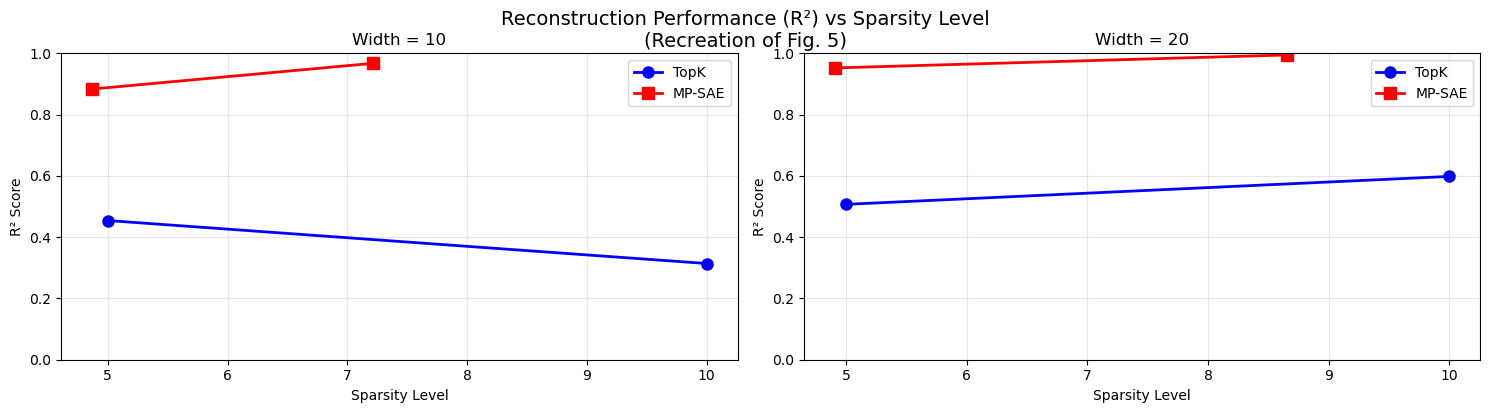


🎯 Step 3: Analyzing cosine similarities...
Training models for cosine similarity analysis (Width=20, Sparsity=10)...
Training TopK SAE...
Epochs: 10, Batches per epoch: 24


Training TopK: 100%|████████████████████████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 10/10, Loss: 0.1158, Sparsity: 10.00
Training MP-SAE SAE...
Epochs: 10, Batches per epoch: 24


Training MP-SAE: 100%|██████████████████████████| 10/10 [00:08<00:00,  1.18it/s]

Epoch 10/10, Loss: 0.0016, Sparsity: 8.36


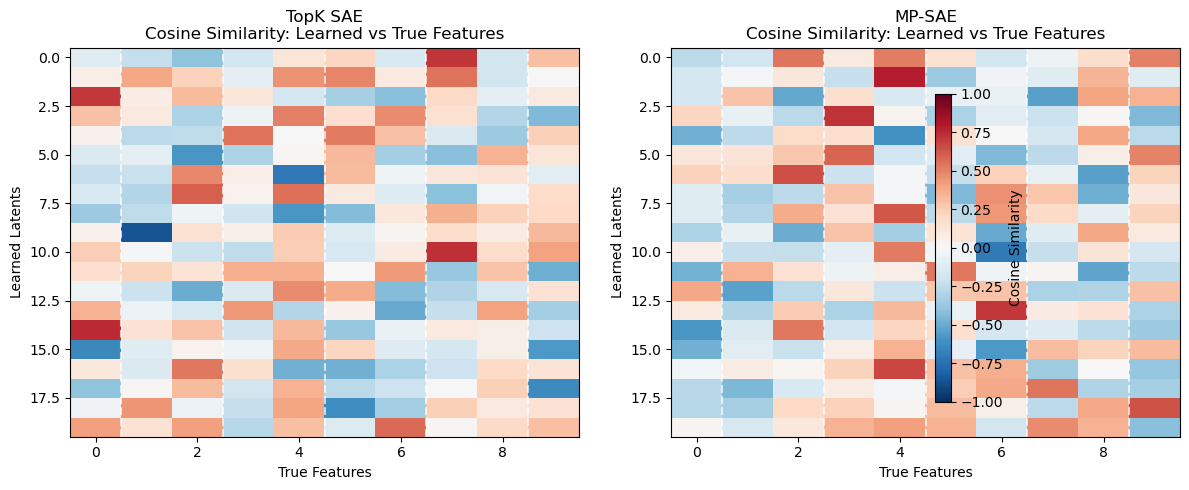


🔍 Step 4: Analyzing feature recovery...

TopK Feature Recovery Analysis:
Feature f0: ✓ Best match: Latent 14, Similarity: 0.744
Feature f1: ✓ Best match: Latent 9, Similarity: -0.862
Feature f2: ✓ Best match: Latent 7, Similarity: 0.594
Feature f3: ✓ Best match: Latent 4, Similarity: 0.545
Feature f4: ✓ Best match: Latent 6, Similarity: -0.718
Feature f5: ✓ Best match: Latent 18, Similarity: -0.622
Feature f6: ✓ Best match: Latent 19, Similarity: 0.567
Feature f7: ✓ Best match: Latent 10, Similarity: 0.731
Feature f8: ✗ Best match: Latent 13, Similarity: 0.399
Feature f9: ✓ Best match: Latent 17, Similarity: -0.636

Overall recovery rate: 90.00%

MP-SAE Feature Recovery Analysis:
Feature f0: ✓ Best match: Latent 14, Similarity: -0.582
Feature f1: ✓ Best match: Latent 12, Similarity: -0.534
Feature f2: ✓ Best match: Latent 6, Similarity: 0.643
Feature f3: ✓ Best match: Latent 3, Similarity: 0.722
Feature f4: ✓ Best match: Latent 1, Similarity: 0.788
Feature f5: ✓ Best match: Latent 11,

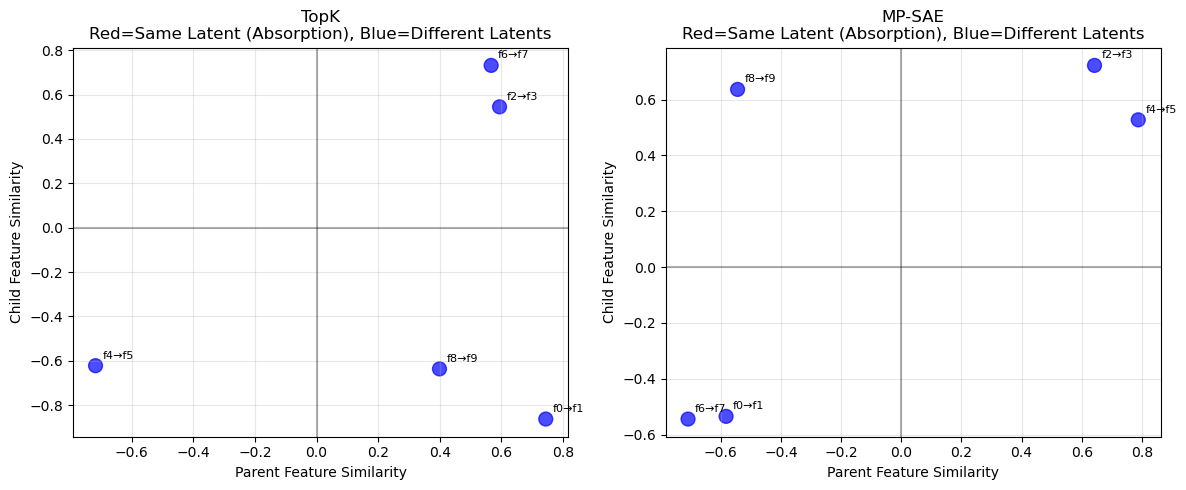


🧠 Step 6: Running interpretability vs reconstruction tradeoff analysis...
Analyzing interpretability: TopK, Width=10, Sparsity=5
Training TopK SAE...
Epochs: 5, Batches per epoch: 24


Training TopK: 100%|██████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Analyzing interpretability: MP-SAE, Width=10, Sparsity=5
Training MP-SAE SAE...
Epochs: 5, Batches per epoch: 24


Training MP-SAE: 100%|████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


Analyzing interpretability: TopK, Width=10, Sparsity=10
Training TopK SAE...
Epochs: 5, Batches per epoch: 24


Training TopK: 100%|██████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


Analyzing interpretability: MP-SAE, Width=10, Sparsity=10
Training MP-SAE SAE...
Epochs: 5, Batches per epoch: 24


Training MP-SAE: 100%|████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


Analyzing interpretability: TopK, Width=20, Sparsity=5
Training TopK SAE...
Epochs: 5, Batches per epoch: 24


Training TopK: 100%|██████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


Analyzing interpretability: MP-SAE, Width=20, Sparsity=5
Training MP-SAE SAE...
Epochs: 5, Batches per epoch: 24


Training MP-SAE: 100%|████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


Analyzing interpretability: TopK, Width=20, Sparsity=10
Training TopK SAE...
Epochs: 5, Batches per epoch: 24


Training TopK: 100%|██████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


Analyzing interpretability: MP-SAE, Width=20, Sparsity=10
Training MP-SAE SAE...
Epochs: 5, Batches per epoch: 24


Training MP-SAE: 100%|████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


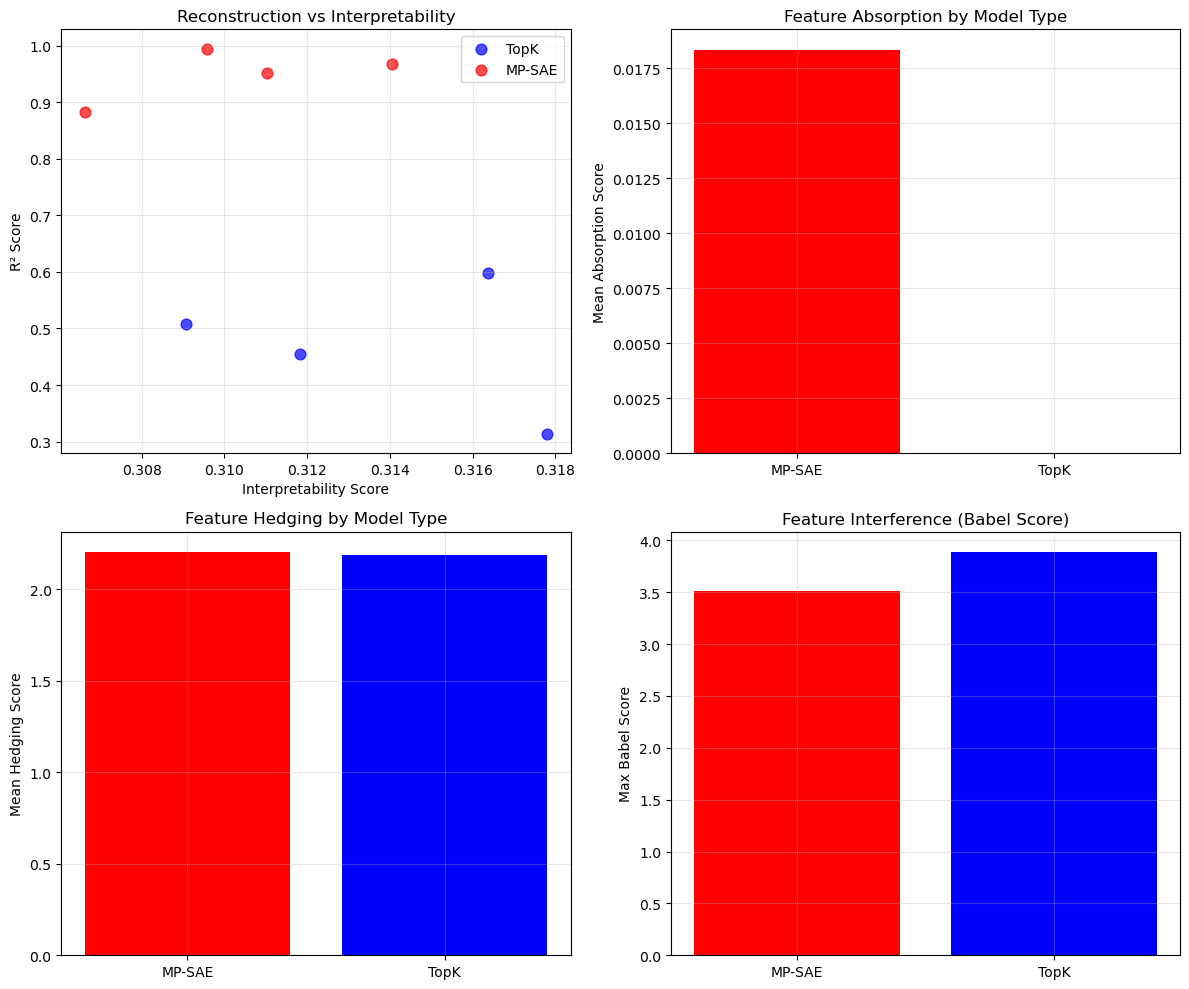


📋 Step 7: Summary Statistics

TopK Summary:
  Mean R²: 0.468 ± 0.119
  Mean Absorption: 0.000
  Mean Hedging: 2.187
  Mean Interpretability: 0.314

MP-SAE Summary:
  Mean R²: 0.949 ± 0.047
  Mean Absorption: 0.018
  Mean Hedging: 2.204
  Mean Interpretability: 0.310

🔑 Key Findings:
1. Reconstruction Quality: MP-SAE outperforms TopK by 0.481 R²
2. Feature Absorption: TopK shows more absorption (diff: -0.018)
3. Feature Hedging: TopK shows more hedging (diff: -0.017)


In [12]:
results_df, interp_df, summary_stats = run_complete_analysis()